## SFN 24 Results Explorer

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imports import *

2024-09-28 14:38:31.142517: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-28 14:38:33.236336: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-28 14:38:35.416118: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from models import *
from data import * 
from env import *
from harmonize import *
from metrics import * 
from sim import *
from sim import multi_sim_run
from sim import plot

In [4]:
# overall imports
import importlib
import data

# data load
importlib.reload(data.data_load)
from data.data_load import load_transcriptome, load_connectome
importlib.reload(data.data_load)

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_X_Y_symmetric_conn_only,
    expand_shared_matrices,
    expand_X_symmetric_w_conn, 
    process_cv_splits, 
    process_cv_splits_conn_only_model, 
    expanded_inner_folds_combined_plus_indices
)

import data.data_utils
importlib.reload(data.data_utils)

# cross-validation classes
import data.cv_split
from data.cv_split import RandomCVSplit, SchaeferCVSplit, CommunityCVSplit, SubnetworkCVSplit
importlib.reload(data.cv_split)

# prebuilt model classes
import models.prebuilt_models
from models.prebuilt_models import ModelBuild
importlib.reload(models.prebuilt_models)

# metric classes
import metrics.distance_FC
import metrics.eval
from metrics.eval import ModelEvaluator
from metrics.eval import pearson_numpy, mse_numpy, r2_numpy, pearson_cupy, mse_cupy, r2_cupy
importlib.reload(metrics.eval)

# sim class
import sim.sim 
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
import sim.multi_sim_run
from sim.sim import Simulation
from sim.multi_sim_run import multi_sim_run, single_sim_run, open_pickled_results, combine_results
importlib.reload(sim.sim)
importlib.reload(sim.sim_utils)
importlib.reload(sim.multi_sim_run)

import sim.plot
from sim.plot import (
    plot_predictions, 
    barplot_model_performance,
    boxplot_model_performance,
    plot_predictions_with_metrics, plot_single_model_predictions_with_metrics,
    plot_best_params_table, plot_best_parameters_table_colored, 
    violin_plot_model_performance, 
    plot_transcriptome_performance_bar, plot_connectome_performance_bar, 
    plot_combined_performance_bar
)

importlib.reload(sim.plot)


<module 'sim.plot' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/plot.py'>

#### Check job specs

In [7]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

GPUtil.getGPUs()

DEVICE_ID_LIST = GPUtil.getFirstAvailable()
DEVICE_ID = DEVICE_ID_LIST[0] # grab first element from list
if DEVICE_ID != None: 
    print('GPU found', DEVICE_ID)
    use_gpu = True

print("XGBoost version:", xgboost.__version__)
print("cupy version:", cp.__version__)

GPUtil.showUtilization()


CPU Usage: 74.9%
RAM Usage: 13.9%
Available RAM: 161.9G
Total RAM: 188.1G
52.4G


RuntimeError: Could not find an available GPU after 1 attempts with 900 seconds interval.

## Table of Contents
- [Random](#Random)
- [Community](#Community)
    - [Single Feature](#single)
    - [Combined_Feature](#combined)

## Random

In [23]:
SFN_sim_path = os.getcwd() + '/sim/sim_results/'
os.listdir(SFN_sim_path)

feature_types = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean', 'functional']

In [61]:
def extract_simulation_metrics(sim_path, subfolder, model_type, cv_type, search_method, feature_types, resolutions=[], seeds=[]):
    """
    Extracts simulation results from pickle files and computes the average Pearson correlation,
    MSE, and standard error over all the folds for the specified parameters.
    
    Args:
    - sim_path: Base directory for the simulations.
    - subfolder: Subfolder within sim_path where simulation results are stored.
    - model_type: The model type used (e.g., 'xgboost', 'pls').
    - cv_type: The cross-validation type (e.g., 'random', 'community').
    - search_method: The search method used (e.g., 'bayessearch', 'gridsearch').
    - feature_types: List of feature types used in simulations (e.g., 'transcriptome', 'euclidean').
    - resolutions: List of resolution values used in simulations. (Can be empty for wildcard)
    - seeds: List of random seed values used in simulations. (Can be empty for wildcard)
    
    Returns:
    - A pandas DataFrame containing the file names and the average Pearson correlation,
      MSE, and standard error for each file.
    """
    
    data = []  # List to store the results
    
    # If resolutions or seeds are empty, set them to a wildcard [''] to ignore the filter
    if not resolutions:
        resolutions = ['']
    if not seeds:
        seeds = ['']
    
    # Iterate over feature types, resolutions, and seeds
    for feature in feature_types:
        for r in resolutions:
            for s in seeds:
                # Construct the expected pickle file name pattern
                resolution_str = str(r).replace('.', '') if r else ''  # If resolution is empty, skip it in the filename
                seed_str = str(s) if s else ''  # If seed is empty, skip it in the filename
                file_pattern = f"{feature}_{model_type}_{cv_type}{resolution_str}_{seed_str}_{search_method}.pickle"
                file_path = os.path.join(sim_path, subfolder, file_pattern)
                
                # Check if the file exists
                if os.path.exists(file_path):
                    # Open the pickle file and load the results
                    with open(file_path, 'rb') as f:
                        results = pickle.load(f)
                    
                    # Extract the metrics for each fold
                    pearson_corrs = []
                    mses = []
                    for fold_result in results[0]:  # Assuming the results are stored in the first element
                        pearson_corrs.append(fold_result['test_metrics']['pearson_corr'])
                        mses.append(fold_result['test_metrics']['mse'])
                    
                    # Compute the mean and standard error
                    mean_pearson_corr = np.mean(pearson_corrs)
                    mean_mse = np.mean(mses)
                    std_err_pearson_corr = np.std(pearson_corrs) / np.sqrt(len(pearson_corrs))
                    std_err_mse = np.std(mses) / np.sqrt(len(mses))
                    
                    # Append the results to the data list
                    data.append({
                        'File Name': file_pattern,
                        'Feature Type': feature,
                        'Mean Pearson Corr': mean_pearson_corr,
                        'Std Err Pearson Corr': std_err_pearson_corr,
                        'Mean MSE': mean_mse,
                        'Std Err MSE': std_err_mse
                    })
                else:
                    print(f"File not found: {file_pattern}")
    
    # Create a DataFrame from the data
    df_results = pd.DataFrame(data)
    
    return df_results

def plot_feature_comparison(df, metric='pearson_corr', margin_factor=0.2):
    """
    Function to create a barplot comparing the performance (Pearson correlation or MSE)
    of different feature types averaged over multiple seeds.

    Args:
    - df: Pandas DataFrame with columns 'Feature Type', 'Mean Pearson Corr', 'Mean MSE', and corresponding std errors.
    - metric: The metric to display, either 'pearson_corr' or 'mse'.
    """
    # Validate metric input
    if metric not in ['pearson_corr', 'mse']:
        raise ValueError("Invalid metric. Choose either 'pearson_corr' or 'mse'.")
    
    # Select the appropriate column based on the chosen metric
    if metric == 'pearson_corr':
        score_column = 'Mean Pearson Corr'
        error_column = 'Std Err Pearson Corr'
        ylabel = 'Pearson Correlation'
    else:
        score_column = 'Mean MSE'
        error_column = 'Std Err MSE'
        ylabel = 'Mean Squared Error (MSE)'
    
    # Group by feature type and calculate the mean and standard error
    df_grouped = df.groupby('Feature Type').agg(
        mean_score=(score_column, 'mean'),
        std_err=(error_column, 'mean')
    ).reset_index()

    # Set the style for an academic journal-style plot
    sns.set(style="whitegrid", context="paper")
    
    # Create the bar plot
    plt.figure(figsize=(8, 6))
    bar_plot = sns.barplot(x='Feature Type', y='mean_score', data=df_grouped, 
                           ci=None, capsize=0.1, edgecolor='black')
    
    # Add error bars manually
    plt.errorbar(x=df_grouped['Feature Type'], y=df_grouped['mean_score'], 
                 yerr=df_grouped['std_err'], fmt='none', c='black', capsize=5)

    # Customize the plot for journal-style aesthetics
    bar_plot.set_title(f'Comparison of Feature Types ({ylabel})', fontsize=14)
    bar_plot.set_xlabel('Feature Type', fontsize=14)
    bar_plot.set_ylabel(ylabel, fontsize=14)
    plt.xticks(rotation=30, ha="right", fontsize=14)
    plt.yticks(fontsize=10)
    
    # Calculate the dynamic upper limit
    max_value = df_grouped['mean_score'].max()
    dynamic_ylim = max_value + (max_value * margin_factor)
    # Set dynamic y-axis limit
    plt.ylim(0, dynamic_ylim)
    
    # Remove the gridlines for a cleaner look
    sns.despine()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

import pandas as pd
from IPython.display import display

def display_results_table(df, feature_types):
    """
    Function to display results in a table format where the first row is the mean Pearson correlation ± std error,
    and the second row is the mean MSE ± std error for each feature type. The best value for Pearson correlation (highest)
    and MSE (lowest) will be bolded.
    
    Args:
    - df: DataFrame containing the results for different feature types.
    - feature_types: List of feature types to include in the table.
    
    Returns:
    - Displays the formatted table.
    """
    
    # Initialize lists to store the mean Pearson correlations, MSE values, and their standard errors
    pearson_corr_means = []
    mse_means = []
    
    # Store numerical values for comparison later
    pearson_corr_values = []
    mse_values = []
    
    # Iterate over each feature type and extract the corresponding mean and std error values
    for feature in feature_types:
        # Filter the DataFrame for the current feature type
        feature_df = df[df['Feature Type'] == feature]
        
        # Compute the mean and std error for Pearson correlation and MSE
        mean_pearson_corr = feature_df['Mean Pearson Corr'].mean()
        std_err_pearson_corr = feature_df['Std Err Pearson Corr'].mean()
        
        mean_mse = feature_df['Mean MSE'].mean()
        std_err_mse = feature_df['Std Err MSE'].mean()
        
        # Store values for later comparison
        pearson_corr_values.append(mean_pearson_corr)
        mse_values.append(mean_mse)
        
        # Format as "mean ± std_error" for both Pearson correlation and MSE
        pearson_corr_means.append(f"{mean_pearson_corr:.3f} ± {std_err_pearson_corr:.3f}")
        mse_means.append(f"{mean_mse:.4f} ± {std_err_mse:.4f}")
    
    # Determine the best values for Pearson correlation (max) and MSE (min)
    best_pearson_idx = np.argmax(pearson_corr_values)  # Index of the highest Pearson correlation
    best_mse_idx = np.argmin(mse_values)  # Index of the lowest MSE
    
    # Bold the best values
    pearson_corr_means[best_pearson_idx] = f"**{pearson_corr_means[best_pearson_idx]}**"
    mse_means[best_mse_idx] = f"**{mse_means[best_mse_idx]}**"
    
    # Create a DataFrame to store the results
    table_df = pd.DataFrame({
        'Feature Type': feature_types,
        'Pearson Correlation': pearson_corr_means,
        'MSE': mse_means
    }).set_index('Feature Type')
    
    # Transpose the table to display metrics as rows and feature types as columns
    table_df_transposed = table_df.T
    
    # Display the table
    display(table_df_transposed)

In [87]:
# Base simulation path
SFN_sim_path = os.getcwd() + '/sim/sim_results/SFN_runs_mse'

# Specify parameters
subfolder = ''
model_type = 'xgboost'
cv_type = 'random'
search_method = 'bayessearch'
feature_types = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean']

resolutions = []  # Empty list to process all resolutions
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 42]  # List of seeds

random_split_results = extract_simulation_metrics(SFN_sim_path, subfolder, model_type, cv_type, search_method, feature_types, resolutions, seeds)

# Display the results
random_split_results

,File Name,Feature Type,Mean Pearson Corr,Std Err Pearson Corr,Mean MSE,Std Err MSE
0,transcriptome_xgboost_random_1_bayessearch.pickle,transcriptome,0.611850,0.041362,0.021448,0.001248
1,transcriptome_xgboost_random_2_bayessearch.pickle,transcriptome,0.606434,0.040769,0.022723,0.001574
2,transcriptome_xgboost_random_3_bayessearch.pickle,transcriptome,0.595530,0.021288,0.020152,0.001251
3,transcriptome_xgboost_random_4_bayessearch.pickle,transcriptome,0.620118,0.050743,0.020988,0.001604
4,transcriptome_xgboost_random_5_bayessearch.pickle,transcriptome,0.589706,0.055733,0.021318,0.002382
5,transcriptome_xgboost_random_6_bayessearch.pickle,transcriptome,0.629444,0.017904,0.021356,0.001284
6,transcriptome_xgboost_random_7_bayessearch.pickle,transcriptome,0.632872,0.020170,0.020600,0.002477
7,transcriptome_xgboost_random_8_bayessearch.pickle,transcriptome,0.619560,0.020748,0.019829,0.000765
8,transcriptome_xgboost_random_9_bayessearch.pickle,transcriptome,0.590182,0.022409,0.021928,0.001752
9,transcriptome_xgboost_random_42_bayessearch.pi...,transcriptome,0.604991,0.043782,0.020732,0.001425


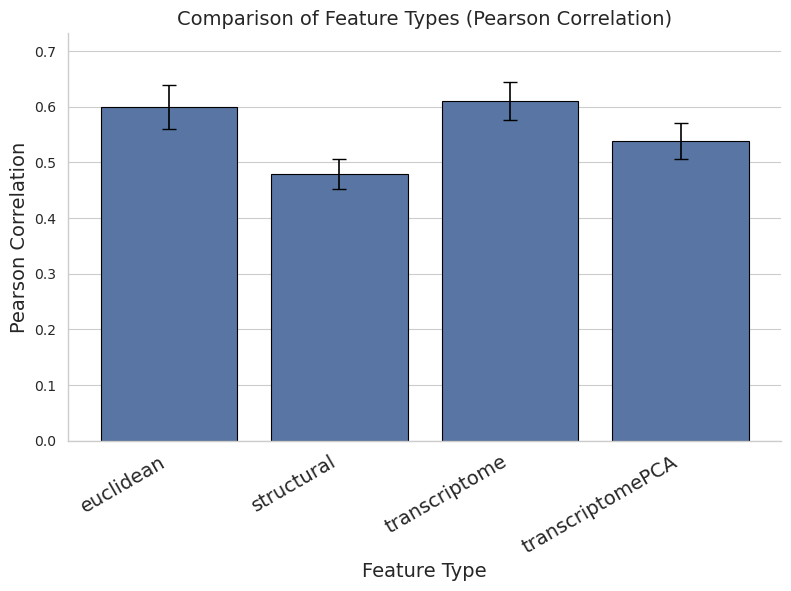

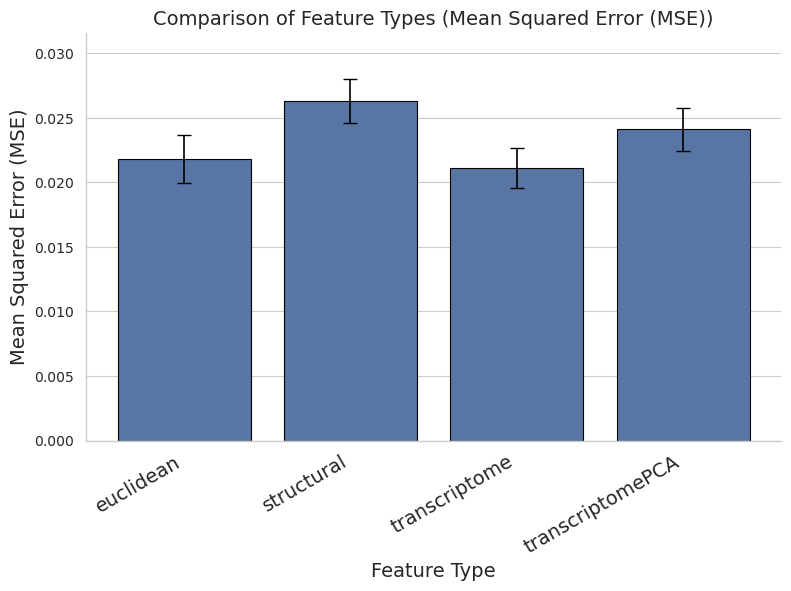

In [88]:
plot_feature_comparison(random_split_results, metric='pearson_corr') 
plot_feature_comparison(random_split_results, metric='mse')

In [89]:
display_results_table(random_split_results, feature_types=['transcriptome', 'transcriptomePCA', 'structural', 'euclidean'])

Feature Type,transcriptome,transcriptomePCA,structural,euclidean
Pearson Correlation,**0.610 ± 0.033**,0.539 ± 0.032,0.479 ± 0.027,0.599 ± 0.039
MSE,**0.0211 ± 0.0016**,0.0241 ± 0.0017,0.0263 ± 0.0017,0.0218 ± 0.0018


## Community

                                            File Name      Feature Type  \
0   transcriptome_xgboost_community101_1_bayessear...     transcriptome   
1   transcriptome_xgboost_community101_2_bayessear...     transcriptome   
2   transcriptome_xgboost_community101_4_bayessear...     transcriptome   
3   transcriptome_xgboost_community101_5_bayessear...     transcriptome   
4   transcriptome_xgboost_community101_42_bayessea...     transcriptome   
5   transcriptomePCA_xgboost_community101_1_bayess...  transcriptomePCA   
6   transcriptomePCA_xgboost_community101_2_bayess...  transcriptomePCA   
7   transcriptomePCA_xgboost_community101_4_bayess...  transcriptomePCA   
8   transcriptomePCA_xgboost_community101_5_bayess...  transcriptomePCA   
9   transcriptomePCA_xgboost_community101_42_bayes...  transcriptomePCA   
10  structural_xgboost_community101_1_bayessearch....        structural   
11  structural_xgboost_community101_2_bayessearch....        structural   
12  structural_xgboost_co

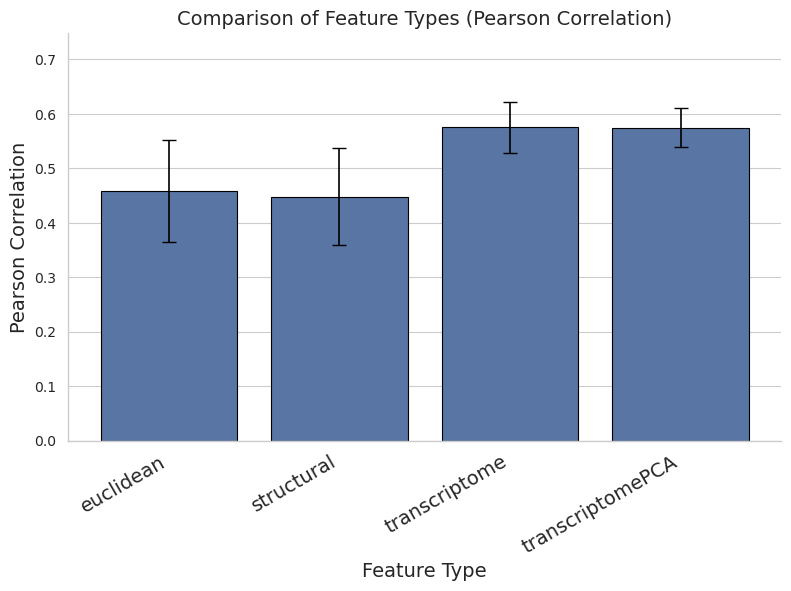

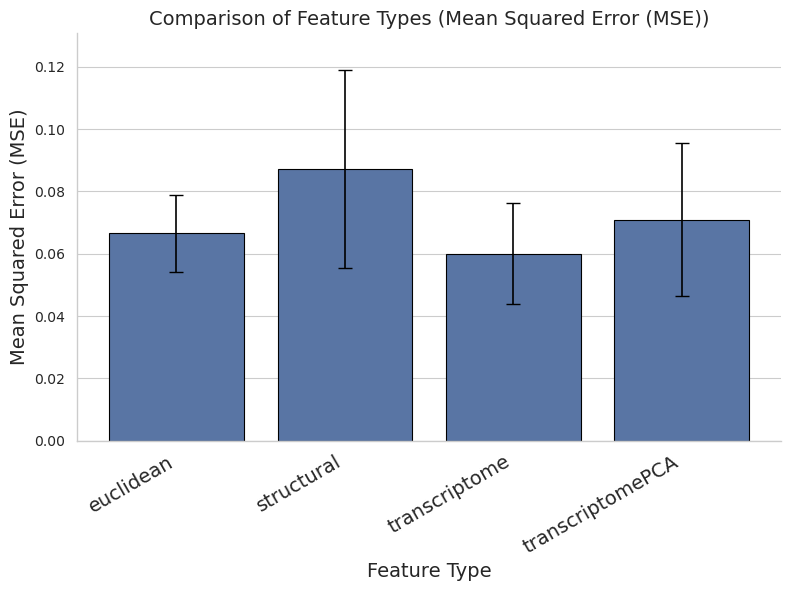

Feature Type,transcriptome,transcriptomePCA,structural,euclidean
Pearson Correlation,**0.576 ± 0.047**,0.575 ± 0.036,0.448 ± 0.089,0.459 ± 0.094
MSE,**0.0599 ± 0.0162**,0.0709 ± 0.0245,0.0872 ± 0.0317,0.0665 ± 0.0124


In [108]:
# Specify parameters
subfolder = ''
model_type = 'xgboost'
cv_type = 'community'
search_method = 'bayessearch'
feature_types = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean']

resolutions = [1.01]  # Empty list to process all resolutions
seeds = [1, 2, 4, 5, 42]  # List of seeds

community_split_results = extract_simulation_metrics(SFN_sim_path, subfolder, model_type, cv_type, search_method, feature_types, resolutions, seeds)

# Display the results
print(community_split_results)

plot_feature_comparison(community_split_results, metric='pearson_corr', margin_factor=0.3)  # To plot Pearson correlation
plot_feature_comparison(community_split_results, metric='mse', margin_factor=0.5)  # To plot MSE

display_results_table(community_split_results, feature_types=['transcriptome', 'transcriptomePCA', 'structural', 'euclidean'])

                                            File Name      Feature Type  \
0   transcriptome_pls_community101_1_gridsearch.pi...     transcriptome   
1   transcriptome_pls_community101_2_gridsearch.pi...     transcriptome   
2   transcriptome_pls_community101_4_gridsearch.pi...     transcriptome   
3   transcriptome_pls_community101_5_gridsearch.pi...     transcriptome   
4   transcriptome_pls_community101_42_gridsearch.p...     transcriptome   
5   transcriptomePCA_pls_community101_1_gridsearch...  transcriptomePCA   
6   transcriptomePCA_pls_community101_2_gridsearch...  transcriptomePCA   
7   transcriptomePCA_pls_community101_4_gridsearch...  transcriptomePCA   
8   transcriptomePCA_pls_community101_5_gridsearch...  transcriptomePCA   
9   transcriptomePCA_pls_community101_42_gridsearc...  transcriptomePCA   
10    structural_pls_community101_1_gridsearch.pickle        structural   
11    structural_pls_community101_2_gridsearch.pickle        structural   
12    structural_pls_comm

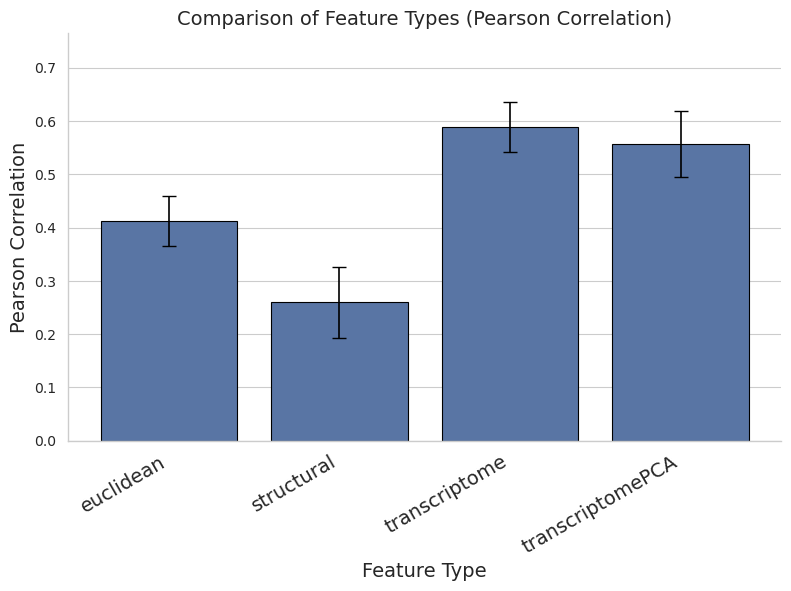

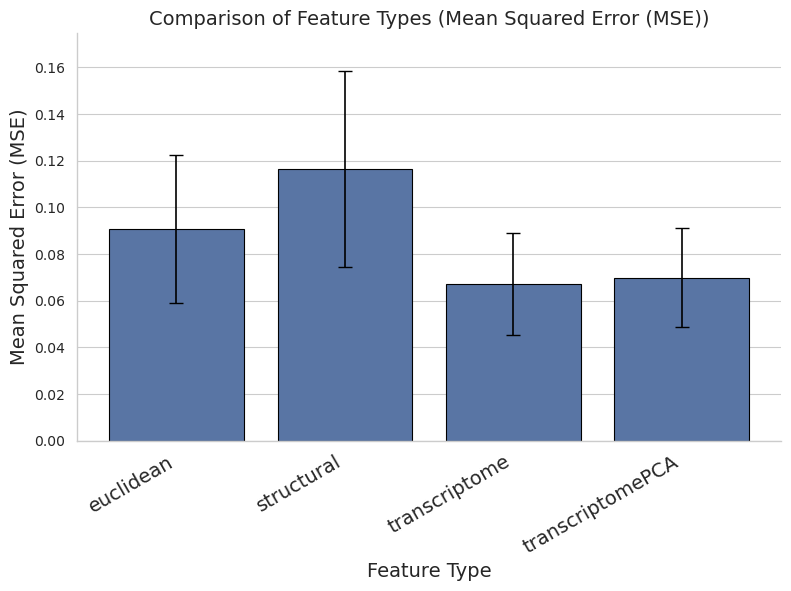

Feature Type,transcriptome,transcriptomePCA,structural,euclidean
Pearson Correlation,**0.588 ± 0.047**,0.557 ± 0.062,0.260 ± 0.066,0.413 ± 0.047
MSE,**0.0670 ± 0.0219**,0.0698 ± 0.0211,0.1164 ± 0.0420,0.0905 ± 0.0317


In [109]:
# Specify parameters
subfolder = ''
model_type = 'pls'
cv_type = 'community'
search_method = 'gridsearch'
feature_types=['transcriptome', 'transcriptomePCA', 'structural', 'euclidean']

resolutions = [1.01]  # Empty list to process all resolutions
seeds = [1, 2, 4, 5, 42]  # List of seeds

community_split_results = extract_simulation_metrics(SFN_sim_path, subfolder, model_type, cv_type, search_method, feature_types, resolutions, seeds)

# Display the results
print(community_split_results)

plot_feature_comparison(community_split_results, metric='pearson_corr', margin_factor=0.3) 
plot_feature_comparison(community_split_results, metric='mse', margin_factor=0.5) 

display_results_table(community_split_results, feature_types=feature_types)

### Feature pairs and triples

In [93]:
feature_pairs = list(itertools.combinations(feature_types, 2))
feature_triples = list(itertools.combinations(feature_types, 3))

['transcriptome transcriptomePCA', 'transcriptome structural', 'transcriptome euclidean', 'transcriptomePCA structural', 'transcriptomePCA euclidean', 'structural euclidean']
                                            File Name  \
0   transcriptome transcriptomePCA_xgboost_communi...   
1   transcriptome transcriptomePCA_xgboost_communi...   
2   transcriptome transcriptomePCA_xgboost_communi...   
3   transcriptome transcriptomePCA_xgboost_communi...   
4   transcriptome transcriptomePCA_xgboost_communi...   
5   transcriptome structural_xgboost_community101_...   
6   transcriptome structural_xgboost_community101_...   
7   transcriptome structural_xgboost_community101_...   
8   transcriptome structural_xgboost_community101_...   
9   transcriptome structural_xgboost_community101_...   
10  transcriptome euclidean_xgboost_community101_1...   
11  transcriptome euclidean_xgboost_community101_2...   
12  transcriptome euclidean_xgboost_community101_4...   
13  transcriptome euclidean

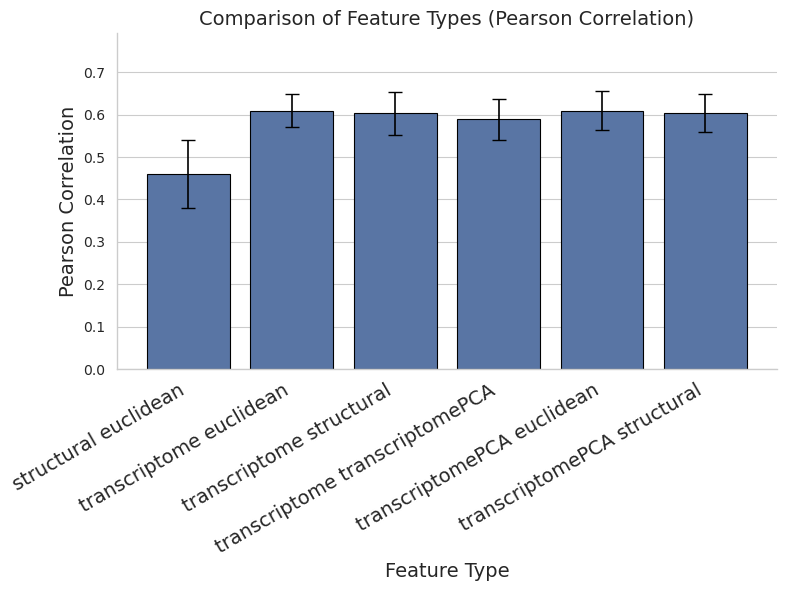

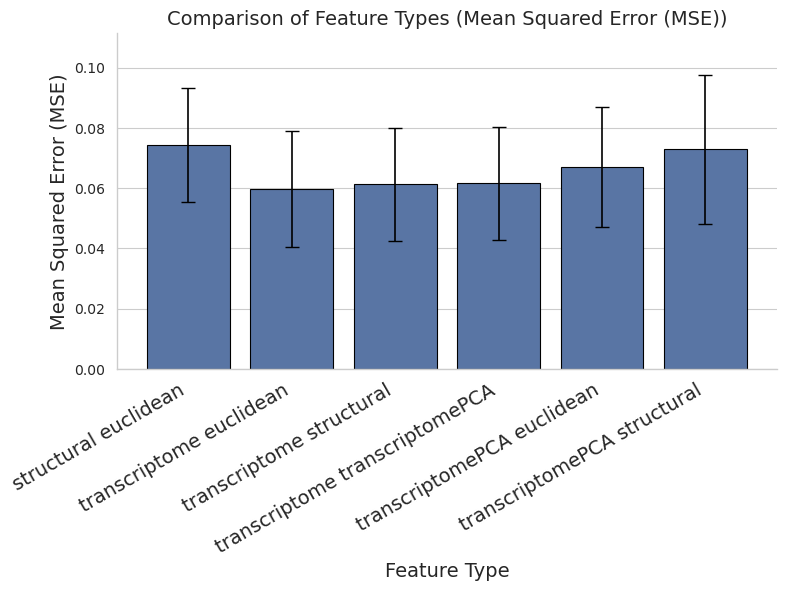

Feature Type,transcriptome transcriptomePCA,transcriptome structural,transcriptome euclidean,transcriptomePCA structural,transcriptomePCA euclidean,structural euclidean
Pearson Correlation,0.589 ± 0.049,0.602 ± 0.051,0.608 ± 0.039,0.604 ± 0.044,**0.609 ± 0.046**,0.459 ± 0.080
MSE,0.0616 ± 0.0189,0.0613 ± 0.0187,**0.0597 ± 0.0193**,0.0729 ± 0.0246,0.0670 ± 0.0200,0.0743 ± 0.0189


In [94]:
# Specify parameters
subfolder = ''
model_type = 'xgboost'
cv_type = 'community'
search_method = 'bayessearch'
feature_types = feature_pairs

# Convert each tuple to a string of format 'feature1 feature2'
feature_types = [' '.join(tup) for tup in feature_types]
print(feature_types)


resolutions = [1.01]  # Empty list to process all resolutions
seeds = [1, 2, 4, 5, 42]  # List of seeds

community_split_results = extract_simulation_metrics(SFN_sim_path, subfolder, model_type, cv_type, search_method, feature_types, resolutions, seeds)

# Display the results
print(community_split_results)

plot_feature_comparison(community_split_results, metric='pearson_corr', margin_factor=0.3) 
plot_feature_comparison(community_split_results, metric='mse', margin_factor=0.5) 

display_results_table(community_split_results, feature_types=feature_types)

['transcriptome transcriptomePCA structural', 'transcriptome transcriptomePCA euclidean', 'transcriptome structural euclidean', 'transcriptomePCA structural euclidean']
File not found: transcriptome transcriptomePCA structural_xgboost_community101_5_bayessearch.pickle
File not found: transcriptome transcriptomePCA structural_xgboost_community101_42_bayessearch.pickle
File not found: transcriptome transcriptomePCA euclidean_xgboost_community101_5_bayessearch.pickle
File not found: transcriptome transcriptomePCA euclidean_xgboost_community101_42_bayessearch.pickle
File not found: transcriptome structural euclidean_xgboost_community101_5_bayessearch.pickle
File not found: transcriptome structural euclidean_xgboost_community101_42_bayessearch.pickle
File not found: transcriptomePCA structural euclidean_xgboost_community101_4_bayessearch.pickle
File not found: transcriptomePCA structural euclidean_xgboost_community101_5_bayessearch.pickle
File not found: transcriptomePCA structural euclidea

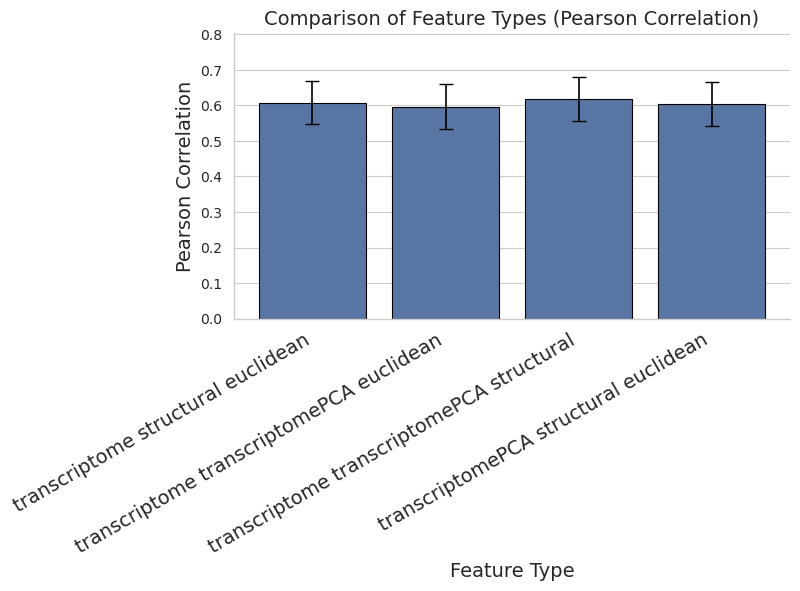

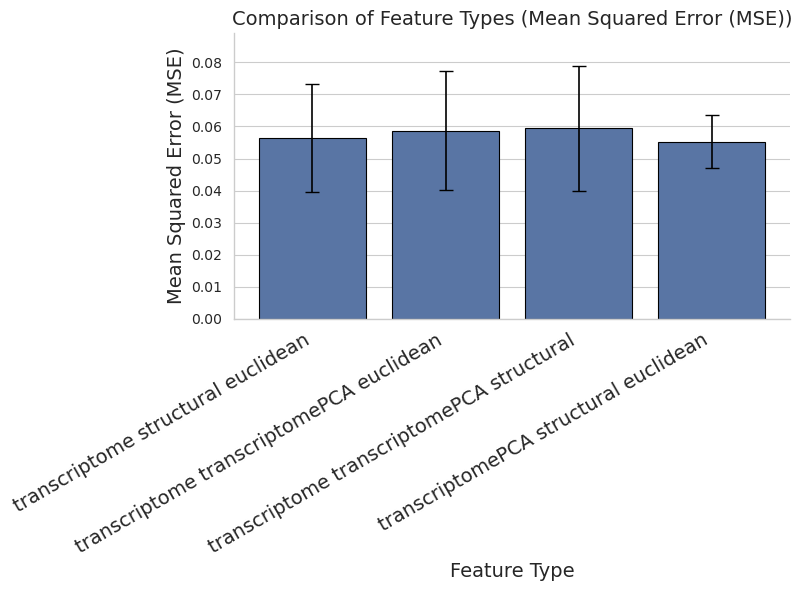

Feature Type,transcriptome transcriptomePCA structural,transcriptome transcriptomePCA euclidean,transcriptome structural euclidean,transcriptomePCA structural euclidean
Pearson Correlation,**0.618 ± 0.062**,0.596 ± 0.063,0.608 ± 0.061,0.603 ± 0.063
MSE,0.0594 ± 0.0194,0.0587 ± 0.0186,0.0564 ± 0.0169,**0.0553 ± 0.0084**


In [95]:
# Specify parameters
subfolder = ''
model_type = 'xgboost'
cv_type = 'community'
search_method = 'bayessearch'
feature_types = feature_triples

# Convert each tuple to a string of format 'feature1 feature2'
feature_types = [' '.join(tup) for tup in feature_types]
print(feature_types)


resolutions = [1.01]  # Empty list to process all resolutions
seeds = [1, 2, 4, 5, 42]  # List of seeds

community_split_results = extract_simulation_metrics(SFN_sim_path, subfolder, model_type, cv_type, search_method, feature_types, resolutions, seeds)

# Display the results
print(community_split_results)

plot_feature_comparison(community_split_results, metric='pearson_corr', margin_factor=0.3) 
plot_feature_comparison(community_split_results, metric='mse', margin_factor=0.5) 

display_results_table(community_split_results, feature_types=feature_types)